Following feature engineering, machine learning can then proceed depending on the required outcomes. A major field in machine learning is <b> supervised learning </b>, where a target variable <i> y </i> is mapped from the inputs <i> X </i>. More formally, this is expressed as

$$y=f(X)$$

where <i> f </i> is the unknown function that maps X to y. Our task as data scientists is to come up with <i> g </i> that captures <i> f </i> closely. Formally,

$$g \simeq f$$

Depending on the task, <i> g </i> may need to output continuous or discrete values. These two tasks are called <b> regression </b> and <b> classification </b>, respectively. Formally, we'll call these tasks <b> creating models</b> that capture the underlying function <i> f </i>. In literature, oftentimes you'll see models also being called as <b> hypothesis </b>.

Let's load up our previous board games data and see our first modeling problem. We want to be able to capture the relationship of total_wanters to total_wishers. In other words, can we predict the number of times a board game is wished for from how it is wanted? (Note that these are two different features of the website.)

#  Linear Regression

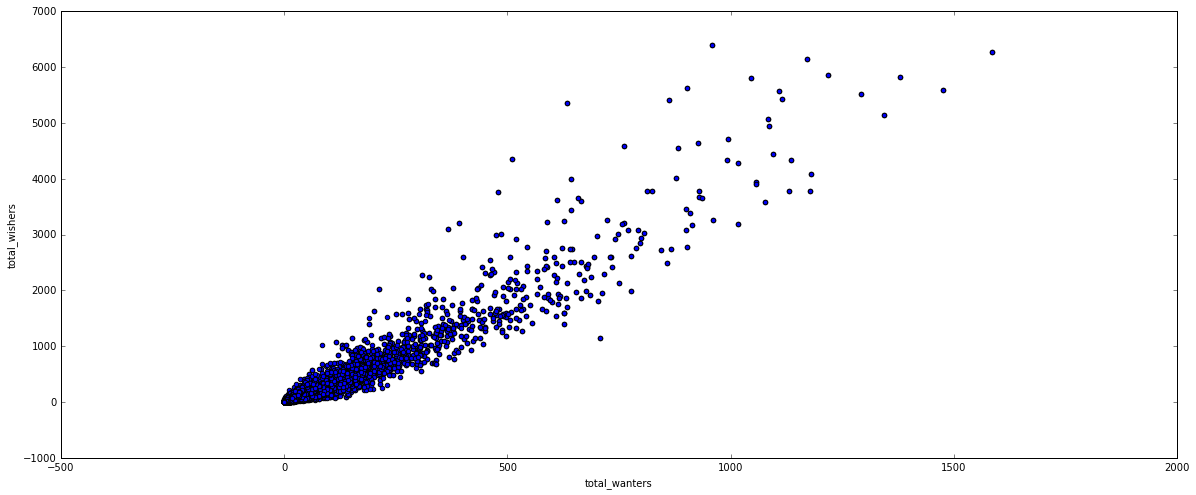

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

board_data = pd.read_csv('data/games.csv')
board_data = board_data[\
            board_data["average_rating"] > 0]
data_wanters_wishers = board_data[\
            ['total_wanters', 'total_wishers']]
subplot = data_wanters_wishers.plot(\
    kind='scatter',x='total_wanters', 
    y='total_wishers', figsize=(20,8))
plt.show()

Now that is clearly a <b> linear relationship </b>. The task of finding a line that best describes this relationship is called <b> linear regression </b> and it is perhaps the most basic yet most fundamental technique in regression. Recall

$$y=mx+b$$

In this case, our y is total_wishers and our x is total_wanters. If we set that into the equation, in layman's terms:

<p>
<center>total_wishers = total_wanters * weight + bias</center>
</p>

where the weight indicates the "slope" of the relationship, and the bias as its translation.

Translating the above to matrix form:

\begin{array}{lcl}
y = mx+b \\
y = \theta_1 * x_1 + b \\
\text{Let }b = \theta_0 \text{ and } x_0 = 1 \\
y = \theta_1 * x_1 + \theta_0 * x_0 \\
y = \sum_{i=0}^{0,1} \theta X^{-1}
\end{array}

Let's try out plotting some lines. Let's go with the line expressed by the weights = [0, 0.5].

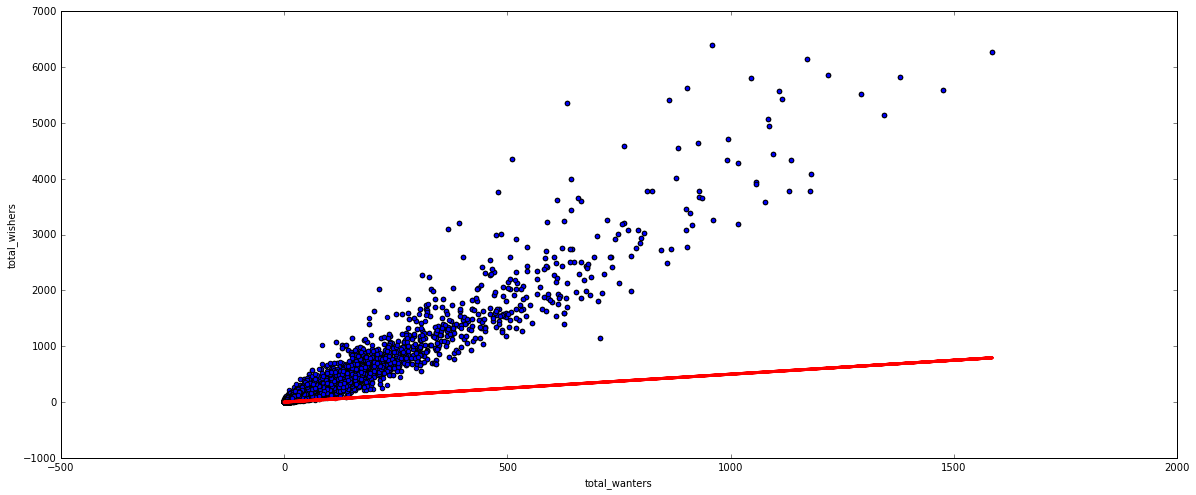

In [3]:
weight_vector = np.float32([0, 0.5])
X_wanters = data_wanters_wishers[['total_wanters']].as_matrix()
m = X_wanters.shape[0]
X_wanters = np.append(np.ones((m,1)), 
                      X_wanters, 1)
predicted = np.dot(weight_vector,
                   X_wanters.T).squeeze()

subplot = data_wanters_wishers.plot(
    kind='scatter',x='total_wanters', 
    y='total_wishers', figsize=(20,8))
subplot.plot(X_wanters[:,1], 
             predicted, color='red', 
             linewidth=3)
plt.show()

Clearly, that isn't a good line to describe this phenomenon. But you get the point, hopefully? <b> Using a linear combination of weights and our input variables </b> we can do regression.

## How to define how good our hypothesis is?

We need to define a function to know how good our hypothesis is. This is called the 
<h3> Cost Function </h3>
... and I can't stress enough that this is one of the most important concept in machine learning. The cost function defines 'how good our model is', how close we are to the goal. For linear regression, one of the most common cost function used is called the root mean squared error.

$$J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=0}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 $$,

where m is the number of dimensions in the data, and superscript <sup> (i) </sup> denotes the dimension number.

<b> Plainly, this just expressed the average of the difference of our hypothesis and our target value, squared. </b> 

Some more observations:

1.) The larger the difference, the worse our hypothesis is.

2.) The larger the difference, the more penalized it is. Squared.

3.) The fraction in the beginning is math magic for easier differentiation later on.

Alright, let's define this in code, and compute the fitness of our earlier [0, 0.5].

In [4]:
def cost_function(thetas, X, y):
    m = X.shape[0]
    X_with_bias = np.append(np.ones((m,1)),
                            X,1)
    predicted = np.dot(X_with_bias, 
                       thetas.T).squeeze()
    
    return sum(np.square(predicted - y)) * (1/(2. * m))

In [29]:
y = data_wanters_wishers\
[['total_wishers']].as_matrix().squeeze()
X = data_wanters_wishers\
[['total_wanters']].as_matrix()
cost_function(np.float32([0, 0.5])\
              .reshape(1,2), X, y)

32500.717342619268

That's not looking too good. Let's enumerate some thetas and graph the cost function results.

Minimum cost is: 3261.0947973, with theta_1: [ 0.  4.]


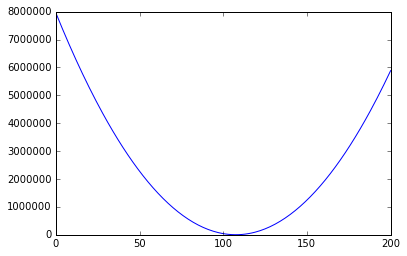

In [8]:
thetas = [np.float32([0,v]) for v in np.linspace(-50,50, num=201)]
cf_results = [cost_function(t, X, y) for t in thetas]

min_idx = np.argmin(cf_results)
print("Minimum cost is: {}, with theta_1: {}".format(cf_results[min_idx], thetas[min_idx]))
plt.plot(cf_results)
plt.show()

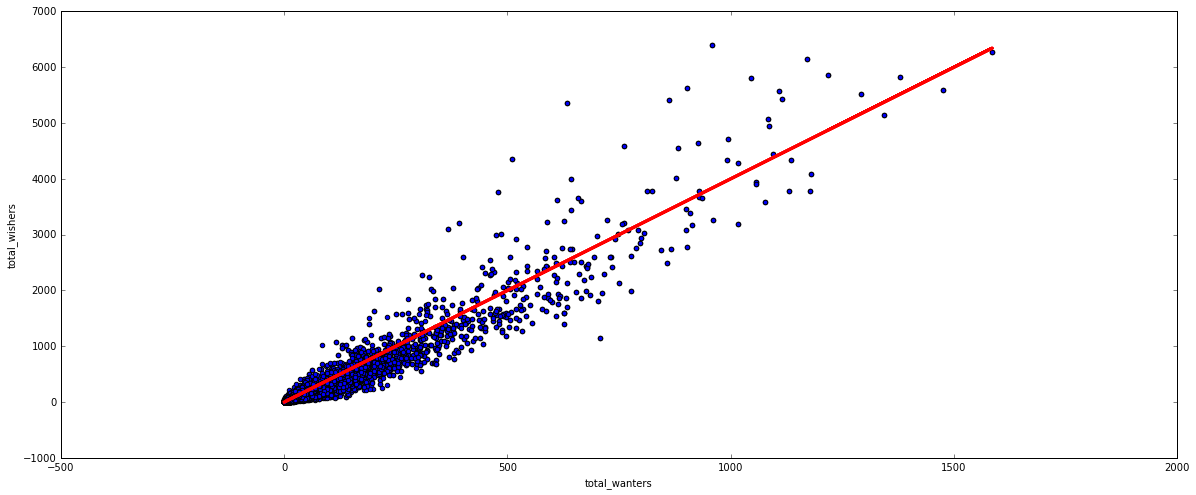

In [94]:
weight_vector = np.float32([0, 4]).reshape(1,2)
predicted = np.dot(X_wanters, weight_vector.T).squeeze()
subplot = data_wanters_wishers.plot(kind='scatter',x='total_wanters', y='total_wishers', figsize=(20,8))
subplot.plot(X_wanters[:,1], predicted, color='red', linewidth=3)
plt.show()

And there you see, the beauty of the root mean squared error cost function for linear regression. It has a single global minimum of [4,0]. Note that the bias is fixed at 0.

Now that we have a function that defines how good our hypothesis is, we then go to how are we going to get those weights? For <b> gradient-based models</b>, we review our derivatives.

## Getting the best weights: Gradient Descent Technique

Imagine we're on that valley above and we want to step down. We look at where we are, see the slope of the ground, then step on the direction of steepest descent. We then repeat.

Mathematically, this is:
$$ \theta_j := \theta_j - \alpha \frac{\partial}{\partial\theta_{j}}J(\theta_0, \theta_1) $$

We won't go to the proof of how to compute the derivative. But it is simply this:

$$\frac{\partial}{\partial\theta_{j}}J(\theta) = \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$$

Here's a picture of what actually happens:

In [95]:
from IPython.display import display, Image
display(Image(url='http://www.holehouse.org/mlclass/17_Large_Scale_Machine_Learning_files/Image%20%5B15%5D.png'))

In [13]:
def step(thetas, X, y):
    m = X.shape[0]
    X_with_bias = np.append(np.ones((m,1)), X,1)
    predicted = np.dot(thetas,X_with_bias.T).squeeze()
    return (1./m) * \
                (np.dot(X_with_bias.T, \
                        predicted - y) )

In [22]:
step(np.float32([0,1]), X, y)

array([   -42.54854915, -15231.76898756])

Okay, then let's repeat this step until we get an cost function value of 3000, OR if our RMSE improvements are really small. BTW, I'm putting this to a header since this is basically gradient descent in its most raw form.

## The raw gradient descent code in Python

In [30]:
weight_vector = np.float32([0,0])
def optimize_grad_descent(weight_vector, X, y,
                          alpha=1e-4,steps=100,
                          verbose=True):
    weights = np.copy(weight_vector)
    grad = step(weights, X, y)
    for _ in range(steps):
        weights -= (alpha * grad)
        grad = step(weights, X, y)
        cost = cost_function(weights, X, y)
        if verbose:
            print("RMSE: {0:.10f}".format(cost))

    return weights, cost

optimized_vector, cost = optimize_grad_descent(weight_vector, X, y, 
                                               alpha=1e-4, steps=100)
print("Minimum weights: {}".format(optimized_vector))

RMSE: 11017.0087742795
RMSE: 4712.5016101588
RMSE: 3437.0437210801
RMSE: 3179.0041148663
RMSE: 3126.7964052460
RMSE: 3116.2301495764
RMSE: 3114.0882932520
RMSE: 3113.6507739567
RMSE: 3113.5580513702
RMSE: 3113.5350874551
RMSE: 3113.5262354731
RMSE: 3113.5202391571
RMSE: 3113.5148217242
RMSE: 3113.5095220670
RMSE: 3113.5042470036
RMSE: 3113.4989777401
RMSE: 3113.4937104318
RMSE: 3113.4884443037
RMSE: 3113.4831792051
RMSE: 3113.4779151144
RMSE: 3113.4726520142
RMSE: 3113.4673899039
RMSE: 3113.4621287803
RMSE: 3113.4568686543
RMSE: 3113.4516095162
RMSE: 3113.4463513634
RMSE: 3113.4410942051
RMSE: 3113.4358380330
RMSE: 3113.4305828518
RMSE: 3113.4253286627
RMSE: 3113.4200754630
RMSE: 3113.4148232438
RMSE: 3113.4095720172
RMSE: 3113.4043217721
RMSE: 3113.3990725240
RMSE: 3113.3938242655
RMSE: 3113.3885769873
RMSE: 3113.3833307014
RMSE: 3113.3780853958
RMSE: 3113.3728410868
RMSE: 3113.3675977611
RMSE: 3113.3623554201
RMSE: 3113.3571140551
RMSE: 3113.3518736877
RMSE: 3113.3466343131
RMSE: 311

## Q: Go modify alpha. Observations?

## Q: Plot the weight change of x1 over the steps.

In [104]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_norm = scaler.fit_transform(X)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


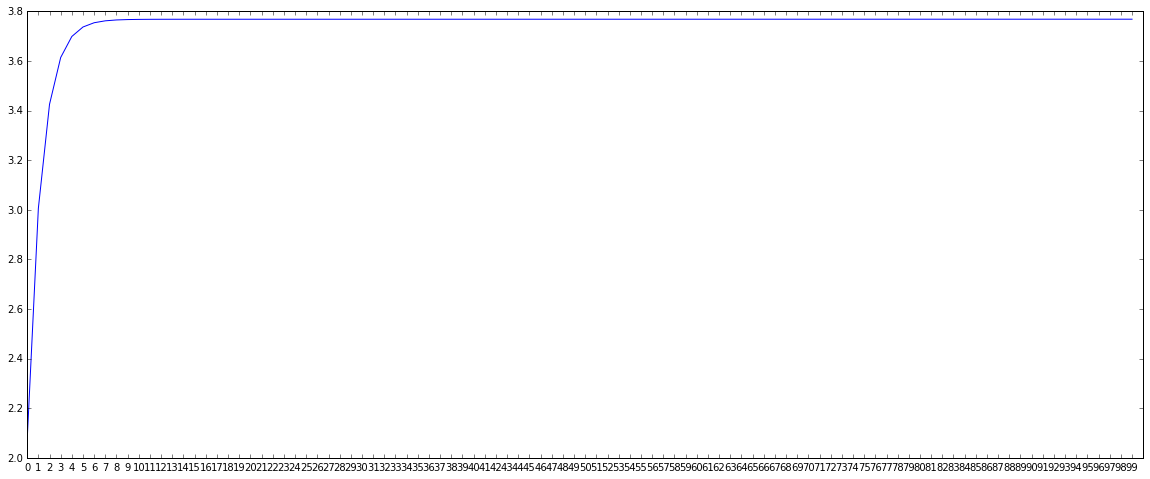

In [112]:
def plot_gradient_descent_weights(weight_vector, X, y,alpha=1e-4,steps=100, verbose=True):
    weights = np.copy(weight_vector)
    grad = step(weights, X, y)
    cost = cost_function(weights, X, y)
    x1_changes = []
    for _ in range(steps):
        weights -= (alpha * grad)
        x1_changes.append(weights[1])
        grad = step(weights, X, y)
        cost = cost_function(weights, X, y)
        
    plt.figure(figsize=(20,8))
    plt.plot(x1_changes)
    plt.xticks(range(len(x1_changes)))
    plt.show()
    
plot_gradient_descent_weights(weight_vector, X, y, steps=100)

## Q: Do gradient descent on total comments and total owners

And here's the amazing part. This code works even though we go to more than 1 dimension. Suppose we get total_comments and total_owners instead.

In [32]:
data_comments_owners_wishers = board_data[['total_comments', 'total_owners', 'total_wishers']]
X = data_comments_owners_wishers[['total_comments','total_owners']].as_matrix()
y = data_comments_owners_wishers[['total_wishers']].as_matrix().squeeze()
weight_vector = np.float32([0,0, 0])

optimize_grad_descent(weight_vector, X, y, alpha=1e-7)

RMSE: 26837.6988276059
RMSE: 20236.3576244476
RMSE: 17395.6396741925
RMSE: 16172.8781294846
RMSE: 15646.2208915546
RMSE: 15419.0534973564
RMSE: 15320.7387122359
RMSE: 15277.8621658636
RMSE: 15258.8382980826
RMSE: 15250.0778084677
RMSE: 15245.7341566309
RMSE: 15243.2919206205
RMSE: 15241.6688751084
RMSE: 15240.3994277727
RMSE: 15239.2832350739
RMSE: 15238.2341244069
RMSE: 15237.2149993339
RMSE: 15236.2099054446
RMSE: 15235.2119817124
RMSE: 15234.2182641159
RMSE: 15233.2274813972
RMSE: 15232.2390797994
RMSE: 15231.2528250306
RMSE: 15230.2686112936
RMSE: 15229.2863865582
RMSE: 15228.3061319009
RMSE: 15227.3278340710
RMSE: 15226.3514928063
RMSE: 15225.3770978993
RMSE: 15224.4046348473
RMSE: 15223.4341066451
RMSE: 15222.4655185862
RMSE: 15221.4988531920
RMSE: 15220.5341158384
RMSE: 15219.5712922687
RMSE: 15218.6103878598
RMSE: 15217.6513956361
RMSE: 15216.6943168494
RMSE: 15215.7391373146
RMSE: 15214.7858696173
RMSE: 15213.8344954854
RMSE: 15212.8850120992
RMSE: 15211.9374166439
RMSE: 15210

(array([ 0.00014248,  0.05242275,  0.11763274], dtype=float32),
 15160.93014869061)

# Surely, there's a better way to do optimization.

Yes, there is. There's a huge field called mathematical optimization that makes all this easier. We will use scikit-learn as the library for machine learning. It is very intuitive and easy to code.

In [25]:
from sklearn import linear_model

In [26]:
regression = linear_model.LinearRegression()

In [33]:
%time
regression.fit(X, y)
print("Thetas: {}" .format(regression.coef_))
print("Bias: {}".format(regression.intercept_))

weight_vector = np.hstack((np.float32(regression.intercept_), np.float32(regression.coef_)))
print("Cost function: {}".format(cost_function(weight_vector, X, y)))
print("R2 score: {}".format(regression.score(X, y)))

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 8.82 µs
Thetas: [ 0.33637274  0.06467055]
Bias: 12.689022335
Cost function: 14659.8309896
R2 score: 0.636659514973


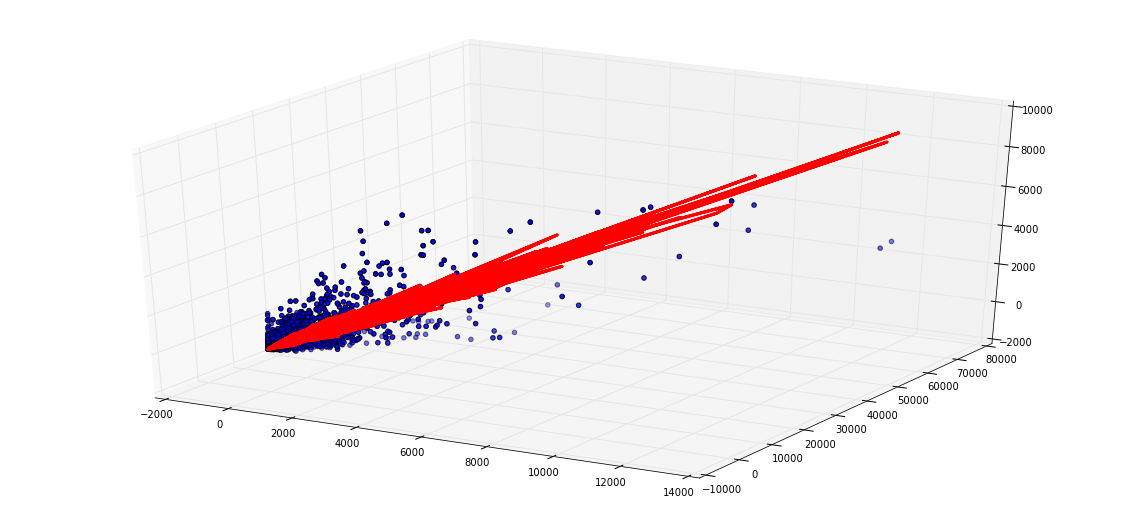

In [126]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,9))

y_pred = regression.predict(X)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, zdir='z', s=20)
ax.plot(X[:,0], X[:,1], y_pred, color='red', linewidth=3)

##  Let's run it for the board game dataset.

But first, let's explain the concept of training and testing. <b>It is not a good practice to fit your model and test it using the same data </b>. I'll explain this in detail later, but I'll give two intutions for now:

1) We are optimizing on the training data, and by definition, we're lessening the error on this data. Surely, the test scores will be extremely high as compared to production environments.

2) The training set we have is not 100% representative of the entire population. We have to account for "unseen" data to simulate partially an unknown sampling of the population.

Therefore, we will divide our data as seen below. Our models will be fitten on the training data, and tested on the testing data. More than often, we'll be wanting to make our models better. To make this optimization process unbiased, we use a validation set to test our data in between optimization techniques (new features, new models, etc.) and then we use a test data for our final unbiased estimator of loss, accuracy, etc.

Lastly, we call <b> generalization </b> the trait of a model having low error on the training set and acceptable error on the test set. 

Sklearn has functions as well to simulate training/validation and testing.

In [127]:
from IPython.display import display, Image
display(Image(url='http://www.intechopen.com/source/html/39037/media/image3.jpeg'))

##  Discrete Values

We have a number of discrete values in our dataset. Remember that linear regression requires numerical values. Thus, we convert our non-numeric columns to numerical, then append that to our original matrix. All these is also part of feature engineering.

Also, an important point: Whatever feature engineering we do to our training set should also be done to the test set, in an unbiased fashion.

In [34]:
# adding duration from the homework
board_data['duration'] = np.where(board_data['maxplaytime'] == board_data['minplaytime'], 
                                   board_data['maxplaytime'],board_data['maxplaytime']-board_data['minplaytime'])
less_than_30_mins = (board_data['duration'] <=30) &  (board_data['duration'] > 0)
one_hour = (board_data['duration'] <=60) & (board_data['duration'] >30)
two_hours = (board_data['duration'] <=120) & (board_data['duration'] >60)
more_than_two_hours = board_data['duration'] > 120
board_data['duration'] = None
board_data.loc[less_than_30_mins,'duration'] = 'Less than 30 minutes'
board_data.loc[one_hour,'duration'] = 'One hour'
board_data.loc[two_hours,'duration'] = 'Two hours'
board_data.loc[more_than_two_hours,'duration'] = 'More than two hours'

In [35]:
numeric_columns = [key for key in dict(board_data.dtypes) 
                   if dict(board_data.dtypes)[key] in ['float64', 'int64','float32','int32']]

In [50]:
# numeric data 
board_data_num = board_data[numeric_columns]
# remove ID since that won't help, removing average_rating since that is the targer
board_data_num= board_data_num.drop(["id", "average_rating"], axis=1)
board_data_num = np.float32(board_data_num.as_matrix())

#categorical data (duration and type)
board_data_cat  = board_data.drop(numeric_columns,axis=1)
# we drop the name (since that won't help in predicting the target)
board_data_cat = board_data_cat.drop(["name"],axis=1)
board_data_cat=board_data_cat.T.to_dict().values()

# vectorizer
from sklearn import feature_extraction
vectorizer = feature_extraction.DictVectorizer(sparse=False)
board_data_cat = vectorizer.fit_transform(board_data_cat)

print(board_data_cat.shape)

(56932, 7)


In [138]:
board_data_cat_ex  = board_data.drop(numeric_columns,axis=1)
# we drop the name (since that won't help in predicting the target)
board_data_cat_ex = board_data_cat_ex.drop(["name"],axis=1)
board_data_cat_ex = board_data_cat_ex.T.to_dict().values()
print(board_data_cat_ex[:5])
print(vectorizer.transform(board_data_cat_ex)[:5])

[{'duration': 'More than two hours', 'type': 'boardgame'}, {'duration': 'Two hours', 'type': 'boardgame'}, {'duration': 'More than two hours', 'type': 'boardgame'}, {'duration': 'More than two hours', 'type': 'boardgame'}, {'duration': 'One hour', 'type': 'boardgame'}]
[[ 0.  0.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  1.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  1.  0.]]


In [45]:
from sklearn import utils
# combine!
board_data_mat = np.hstack((board_data_num, board_data_cat))
# remove nans
where_are_NaNs = np.isnan(board_data_mat)
board_data_mat[where_are_NaNs] = -1

# shuffle along with the target variable
y = board_data["average_rating"].tolist()
board_data_mat, y = utils.shuffle(board_data_mat, y)

# then we finally split the data
X_test = board_data_mat[:22000]
y_test = y[:22000]
X_train = board_data_mat[22000:]
y_train = y[22000:]
print X_test.shape
print X_train.shape

(22000, 23)
(34932, 23)


In [47]:
from sklearn import cross_validation, metrics

regression = linear_model.LinearRegression()
print cross_validation.cross_val_score(regression, X_train, y_train,
                                          cv=5, scoring='r2')
print cross_validation.cross_val_score(regression, X_train, y_train,
                                          cv=5, scoring='mean_squared_error')

[ 0.23357235  0.23448374  0.23178435  0.24146568  0.22571706]
[-1.9419973  -1.88253335 -1.94440057 -1.90540256 -1.92659693]


## With less variables

In [143]:
# Get all the columns from the dataframe.
columns = board_data.columns.tolist()
# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in [\
           "average_rating", "type",
            "name","id","duration"]]

# Store the variable we'll be predicting on.
target = "average_rating"

from sklearn.cross_validation import train_test_split

# Generate the training set.  Set random_state to be able to replicate results.
train = board_data.sample(frac=0.8, random_state=1)
# Select anything not in the training set and put it in the testing set.
test = board_data.loc[~board_data.index.isin(train.index)]

# remove nans
train_data = train[columns]
train_data = train_data.fillna(-1)

regression = linear_model.LinearRegression()
# print cross_validation.cross_val_score(regression, train_data, train[target],
#                                           cv=5, scoring='r2')
# print cross_validation.cross_val_score(regression, train_data, train[target],
#                                           cv=5, scoring='mean_squared_error')

regression.fit(train_data, train[target])

from sklearn.metrics import mean_squared_error,r2_score

print("Test set")

# Generate our predictions for the test set.
predictions = regression.predict(test[columns])

# Compute error between our test predictions and the actual values.
print mean_squared_error(test[target], predictions)
print r2_score(test[target], predictions)

print("Test set using all variables")
regression.fit(X_train, y_train)
predictions = regression.predict(X_test)
print mean_squared_error(y_test, predictions)
print r2_score(y_test, predictions)

Test set
2.1214209229
0.148370293407
Test set using all variables
1.89790192266
0.236455956571


Do you want to improve this? Well, wait next week for a chapter on more complex models and regularization.